# Explore Exercises

In [1]:
# regular imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import math
import env

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

import warnings
warnings.filterwarnings("ignore")

# Wrangling
from sklearn.model_selection import train_test_split, learning_curve

# Personal Imports
import acquire
import prepare
import explore

In [2]:
df = acquire.wrangle_zillow()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52441 entries, 0 to 52440
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   typeconstructiontypeid        76 non-null     float64
 1   heatingorsystemtypeid         33935 non-null  float64
 2   buildingclasstypeid           0 non-null      object 
 3   architecturalstyletypeid      70 non-null     float64
 4   airconditioningtypeid         13638 non-null  float64
 5   propertylandusetypeid         52441 non-null  float64
 6   id                            52441 non-null  int64  
 7   parcelid                      52441 non-null  int64  
 8   logerror                      52441 non-null  float64
 9   transactiondate               52441 non-null  object 
 10  id                            52441 non-null  int64  
 11  parcelid                      52441 non-null  int64  
 12  basementsqft                  47 non-null     float64
 13  b

In [3]:
df.head()

,typeconstructiontypeid,heatingorsystemtypeid,buildingclasstypeid,architecturalstyletypeid,airconditioningtypeid,propertylandusetypeid,id,parcelid,logerror,transactiondate,...,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,propertylandusedesc,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,typeconstructiondesc
0,NaN,NaN,None,NaN,NaN,261.00,0,14297519,0.03,2017-01-01,...,"11,013.72",None,NaN,"60,590,630,072,012.00",Single Family Residential,None,None,None,None,None
1,NaN,NaN,None,NaN,NaN,261.00,1,17052889,0.06,2017-01-01,...,"5,672.48",None,NaN,"61,110,010,023,006.00",Single Family Residential,None,None,None,None,None
2,NaN,NaN,None,NaN,NaN,261.00,2,14186244,0.01,2017-01-01,...,"6,488.30",None,NaN,"60,590,218,022,012.00",Single Family Residential,None,None,None,None,None
3,NaN,2.00,None,NaN,NaN,261.00,3,12177905,-0.10,2017-01-01,...,"1,777.51",None,NaN,"60,373,001,001,006.00",Single Family Residential,None,None,None,Central,None
4,NaN,2.00,None,NaN,1.00,261.00,6,12095076,-0.00,2017-01-01,...,"9,516.26",None,NaN,"60,374,608,001,014.00",Single Family Residential,Central,None,None,Central,None


In [4]:
df, train, validate, test, x_train, y_train, x_validate, y_validate, x_test, y_test = prepare.prep_zillow(df)

In [5]:
print(df.shape)
print(train.shape)
print(validate.shape)
print(test.shape)

(48267, 34)
(27029, 34)
(11584, 34)
(9654, 34)


In [6]:
train.propertycountylandusecode

3851     0100
37413    0100
1019     1111
20714    0100
52147    0104
         ... 
48758    0101
24068    0100
35448    1111
15738    1111
20163    0100
Name: propertycountylandusecode, Length: 27029, dtype: object

In [7]:
train.head()

,id,parcelid,logerror,transactiondate,id,parcelid,bathrooms,bedrooms,calculatedbathnbr,sq_ft,...,unitcnt,year_built,structuretaxvaluedollarcnt,home_value,assessmentyear,landtaxvaluedollarcnt,censustractandblock,propertylandusedesc,decade_built,county_encoded
3851,5725,12771318,-0.08,2017-01-26,2469290,12771318,2.00,3,2.00,1019,...,1.00,1955,"73,944.00",208797,2016,"134,853.00","60,374,338,013,013.00",Single Family Residential,50s,0
37413,55244,12486082,0.05,2017-07-07,634095,12486082,2.00,3,2.00,1632,...,1.00,1950,"128,091.00",431260,2016,"303,169.00","60,375,711,014,006.00",Single Family Residential,50s,0
1019,1526,17240151,0.02,2017-01-09,2074034,17240151,2.00,3,2.00,1466,...,0.00,1977,"309,000.00",582000,2016,"273,000.00","61,110,084,021,036.00",Single Family Residential,70s,2
20714,30868,12212222,-0.10,2017-04-28,230310,12212222,2.00,4,2.00,1120,...,1.00,2003,"142,642.00",261781,2016,"119,139.00","60,372,400,201,005.00",Single Family Residential,2000s,0
52147,77146,12872167,0.04,2017-09-15,2842513,12872167,2.00,3,2.00,1089,...,1.00,1957,"127,739.00",236131,2016,"108,392.00","60,374,027,032,013.00",Single Family Residential,50s,0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27029 entries, 3851 to 20163
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          27029 non-null  int64   
 1   parcelid                    27029 non-null  int64   
 2   logerror                    27029 non-null  float64 
 3   transactiondate             27029 non-null  object  
 4   id                          27029 non-null  int64   
 5   parcelid                    27029 non-null  int64   
 6   bathrooms                   27029 non-null  float64 
 7   bedrooms                    27029 non-null  int64   
 8   calculatedbathnbr           27029 non-null  float64 
 9   sq_ft                       27029 non-null  int64   
 10  finishedsquarefeet12        27029 non-null  float64 
 11  location                    27029 non-null  object  
 12  full_bathrooms              27029 non-null  float64 
 13  garage_spaces

# Main Exploration

In [9]:
# Create separate train sample that removes troublesome variables 
train_explore = train.drop(['id','parcelid','propertylandusedesc','decade_built','location','transactiondate','propertycountylandusecode','propertylandusedesc'], axis=1)

In [10]:
train_explore.head()

,logerror,bathrooms,bedrooms,calculatedbathnbr,sq_ft,finishedsquarefeet12,full_bathrooms,garage_spaces,garagetotalsqft,latitude,...,regionidzip,roomcnt,unitcnt,year_built,structuretaxvaluedollarcnt,home_value,assessmentyear,landtaxvaluedollarcnt,censustractandblock,county_encoded
3851,-0.08,2.00,3,2.00,1019,"1,019.00",2.00,0.00,0.00,"34,041,564.00",...,"96,480.00",0.00,1.00,1955,"73,944.00",208797,2016,"134,853.00","60,374,338,013,013.00",0
37413,0.05,2.00,3,2.00,1632,"1,632.00",2.00,0.00,0.00,"33,846,131.00",...,"96,213.00",0.00,1.00,1950,"128,091.00",431260,2016,"303,169.00","60,375,711,014,006.00",0
1019,0.02,2.00,3,2.00,1466,"1,466.00",2.00,2.00,457.00,"34,286,961.00",...,"97,116.00",6.00,0.00,1977,"309,000.00",582000,2016,"273,000.00","61,110,084,021,036.00",2
20714,-0.10,2.00,4,2.00,1120,"1,120.00",2.00,0.00,0.00,"33,955,012.00",...,"95,984.00",0.00,1.00,2003,"142,642.00",261781,2016,"119,139.00","60,372,400,201,005.00",0
52147,0.04,2.00,3,2.00,1089,"1,089.00",2.00,0.00,0.00,"34,077,651.00",...,"96,507.00",0.00,1.00,1957,"127,739.00",236131,2016,"108,392.00","60,374,027,032,013.00",0


In [ ]:
# Drops duplicate id and parcelid vars
# train = train.drop(['id','parcelid'], axis=1)

In [11]:
train_explore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27029 entries, 3851 to 20163
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   logerror                    27029 non-null  float64
 1   bathrooms                   27029 non-null  float64
 2   bedrooms                    27029 non-null  int64  
 3   calculatedbathnbr           27029 non-null  float64
 4   sq_ft                       27029 non-null  int64  
 5   finishedsquarefeet12        27029 non-null  float64
 6   full_bathrooms              27029 non-null  float64
 7   garage_spaces               27029 non-null  float64
 8   garagetotalsqft             27029 non-null  float64
 9   latitude                    27029 non-null  float64
 10  longitude                   27029 non-null  float64
 11  lot_sq_ft                   27029 non-null  float64
 12  poolcnt                     27029 non-null  float64
 13  regionidcity                

In [12]:
train.year_built.head()

3851     1955
37413    1950
1019     1977
20714    2003
52147    1957
Name: year_built, dtype: int64

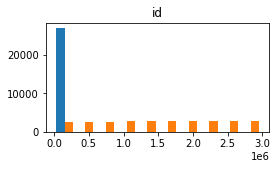

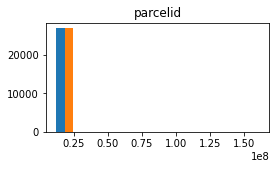

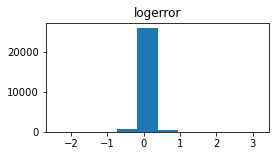

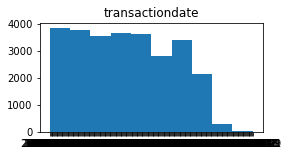

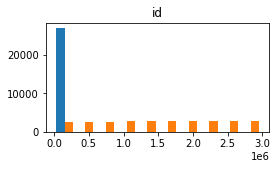

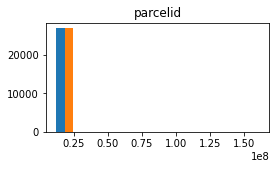

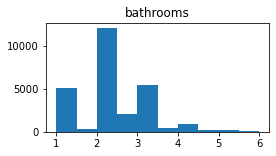

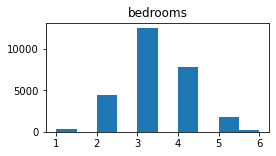

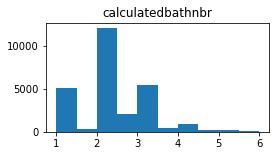

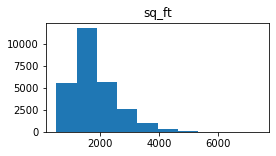

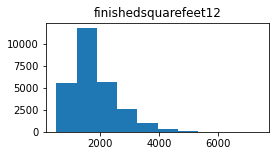

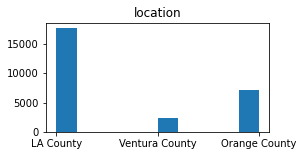

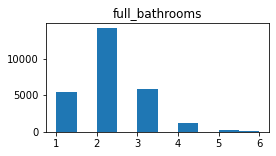

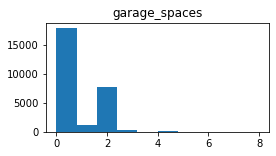

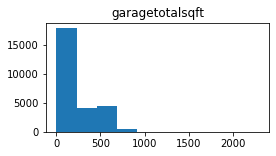

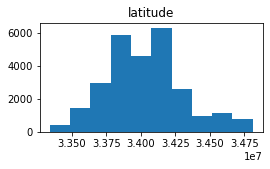

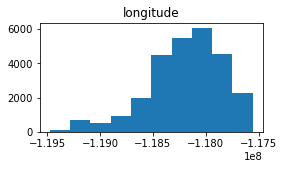

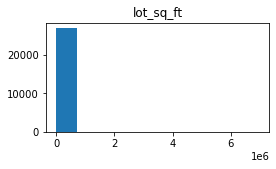

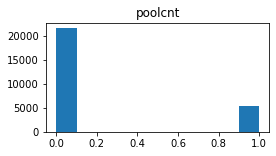

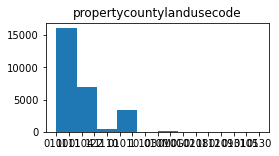

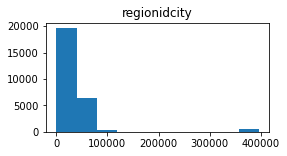

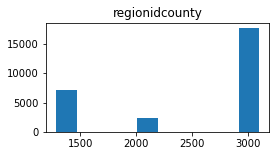

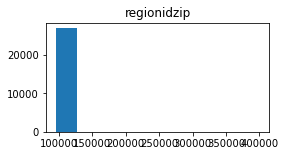

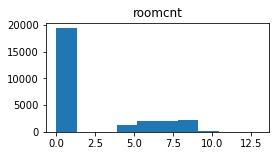

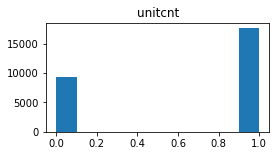

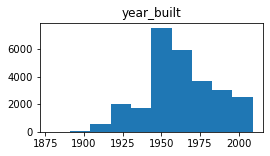

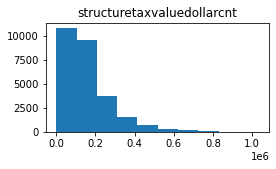

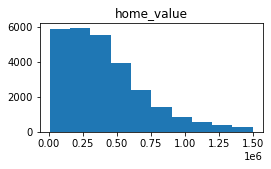

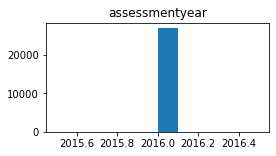

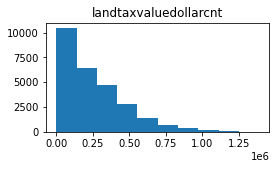

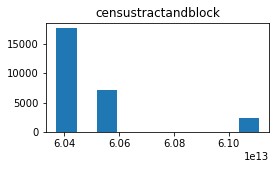

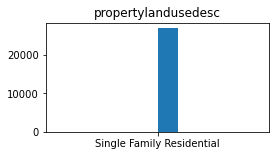

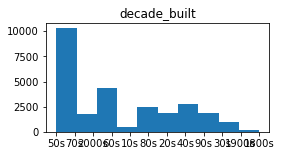

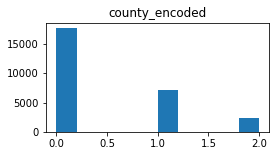

In [13]:
# loop for distribution of all variables, via histogram:
for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

In [14]:
train_explore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27029 entries, 3851 to 20163
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   logerror                    27029 non-null  float64
 1   bathrooms                   27029 non-null  float64
 2   bedrooms                    27029 non-null  int64  
 3   calculatedbathnbr           27029 non-null  float64
 4   sq_ft                       27029 non-null  int64  
 5   finishedsquarefeet12        27029 non-null  float64
 6   full_bathrooms              27029 non-null  float64
 7   garage_spaces               27029 non-null  float64
 8   garagetotalsqft             27029 non-null  float64
 9   latitude                    27029 non-null  float64
 10  longitude                   27029 non-null  float64
 11  lot_sq_ft                   27029 non-null  float64
 12  poolcnt                     27029 non-null  float64
 13  regionidcity                

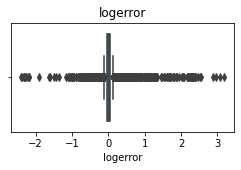

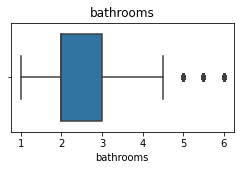

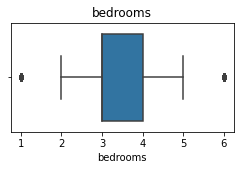

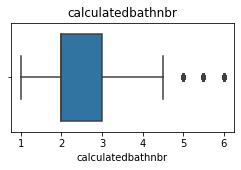

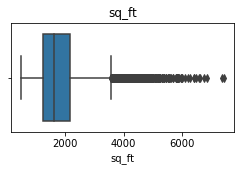

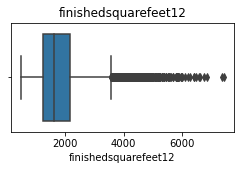

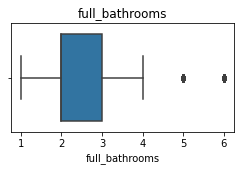

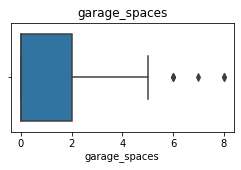

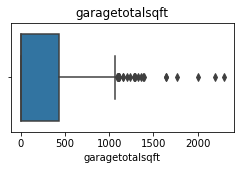

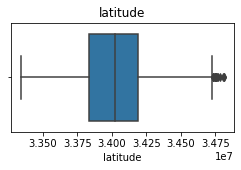

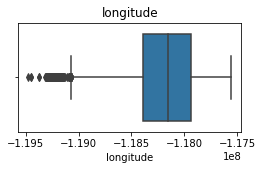

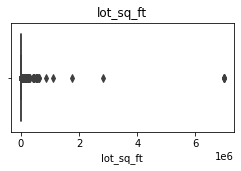

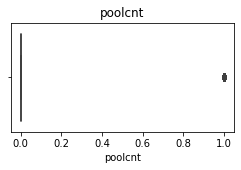

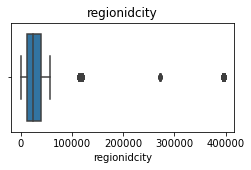

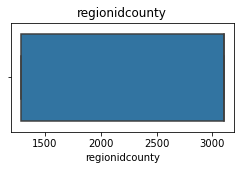

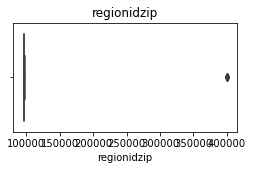

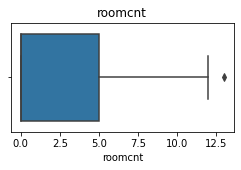

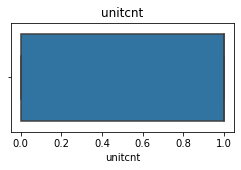

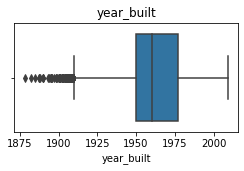

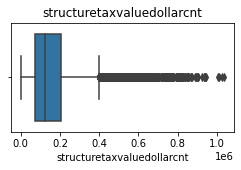

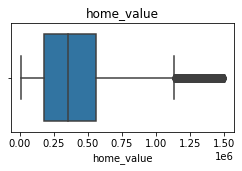

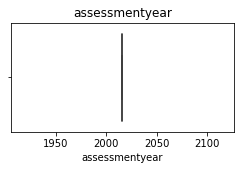

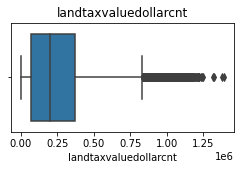

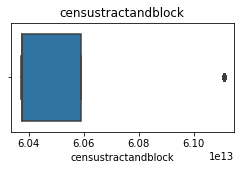

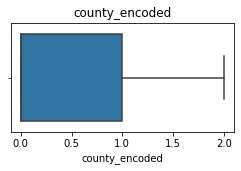

In [15]:
for col in train_explore.columns:
    plt.figure(figsize=(4,2))
    sns.boxplot(train_explore[col])
    plt.title(col)
    plt.show()

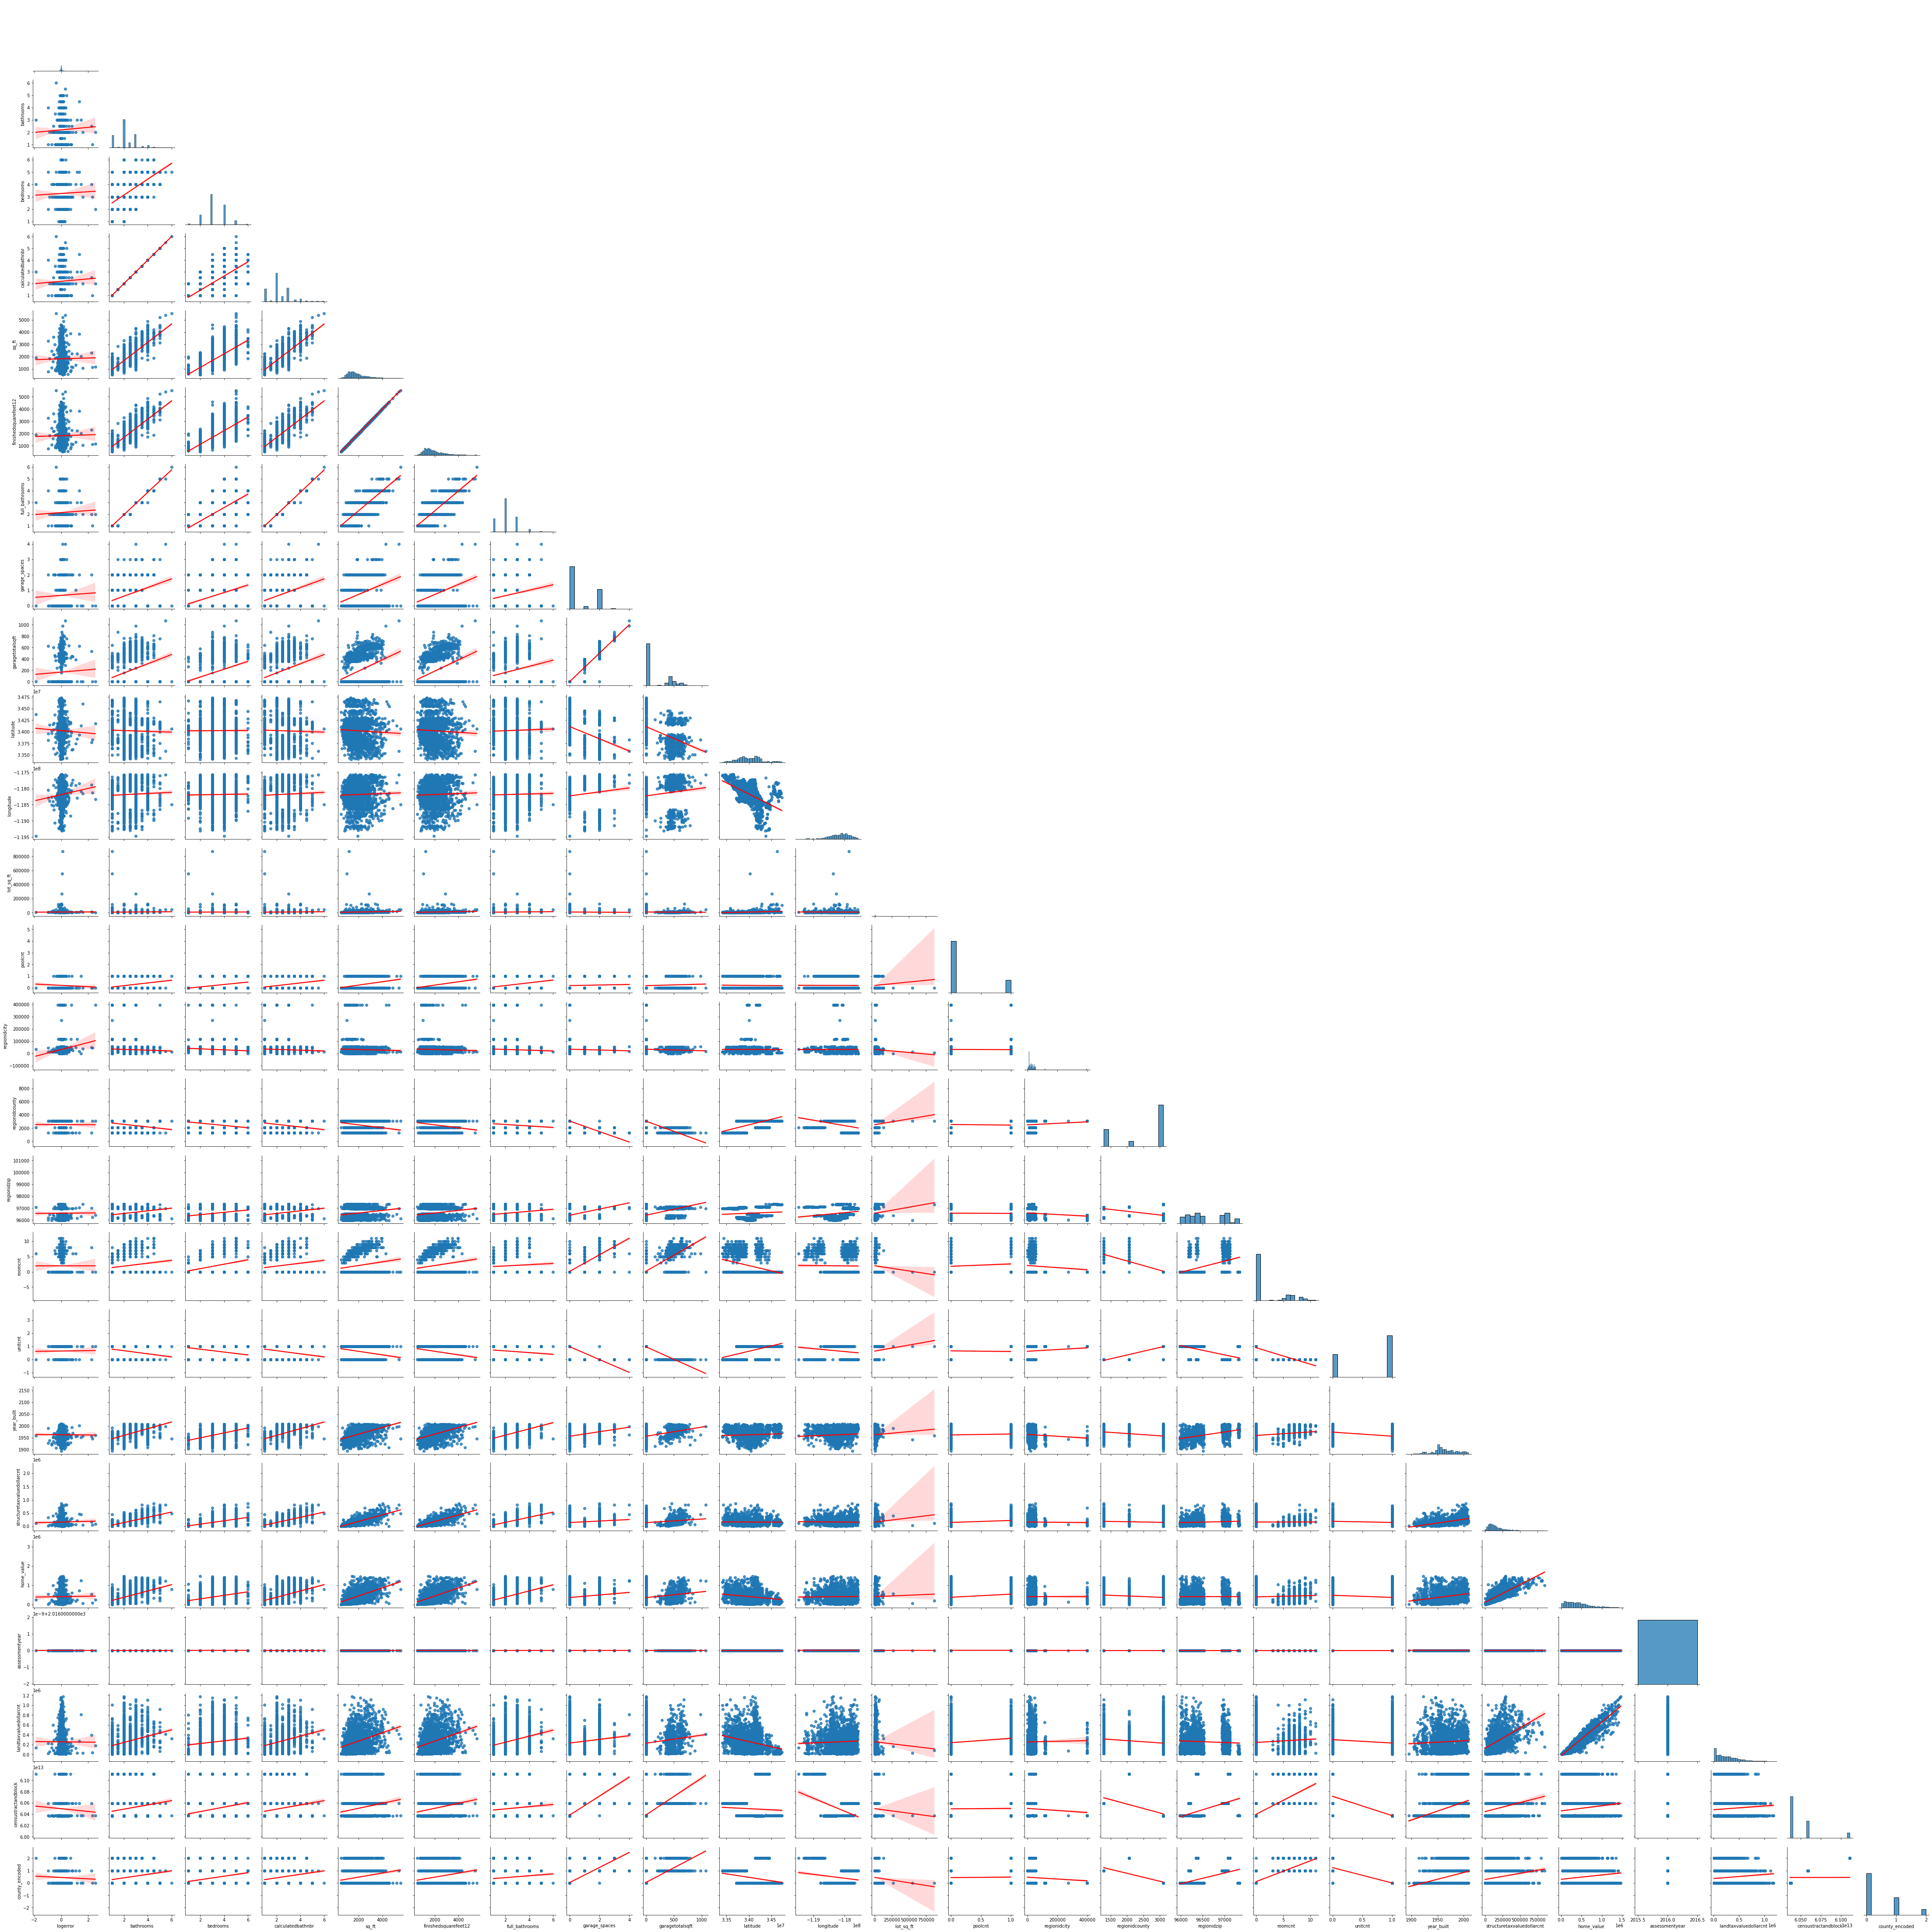

In [16]:
# Creating a snapshot of our data, variables, and their relationships
sns.pairplot(train_explore.sample(2000), kind='reg', corner=True, plot_kws={'line_kws':{'color':'red'}})

In [17]:
train_explore.year_built.dtype

dtype('int64')

In [24]:
train.censustractandblock.nunique()

19827

In [25]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27029 entries, 3851 to 20163
Data columns (total 34 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   id                          27029 non-null  int64   
 1   parcelid                    27029 non-null  int64   
 2   logerror                    27029 non-null  float64 
 3   transactiondate             27029 non-null  object  
 4   id                          27029 non-null  int64   
 5   parcelid                    27029 non-null  int64   
 6   bathrooms                   27029 non-null  float64 
 7   bedrooms                    27029 non-null  int64   
 8   calculatedbathnbr           27029 non-null  float64 
 9   sq_ft                       27029 non-null  int64   
 10  finishedsquarefeet12        27029 non-null  float64 
 11  location                    27029 non-null  object  
 12  full_bathrooms              27029 non-null  float64 
 13  garage_spaces

In [26]:
## Exploring Censustractandblock
# Barplot expressing churn rate of customers by payment type: bank transfer, cc, e-check, mailed-check
variables = ['censustractandblock', 'logerror']

mean = [train['censustractandblock'].mean()]

for x in range(0,4):
    sns.barplot('logerror',variables[x], data=train)
    
    plt.xlabel('')
    plt.title(variables[x])
    plt.axhline(mean[x], ls = '--', color = 'black')
    plt.show()

KeyboardInterrupt: 

# Initial Questions and Hypotheses

1. does 

# plotly 3d scatter
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width',
              color='species')
fig.update_layout(width=700, height=500)
# fig.update_layout(margin={"r":0,"t":0,"l":10,"b":0})
fig.show()